In [1]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
from dataclasses import asdict


from experiment import run_experiment, Config
from svrg import SvrgConfig
from catalyst import CatalystConfig
from recapp import RecappConfig
from datasets import load_data
from objectives import FiniteSumObjective

from matplotlib import pyplot as plt
from IPython import display

In [2]:
base_config = Config(
                output_dir='', # disables saving results to file
                log_to_stderr=True,
                data_n = -1,
                dataset='a9a', 
                loss_type='logistic',
                loss_l2_reg=0.0,
                complexity_budget=50,
                seed=12,
               )

alg_configs = dict(svrg=SvrgConfig(epoch_length=2, step_size=1.0, tail_averaging_fraction=0.5),
                   catalyst=CatalystConfig(prox_lambda=0.1, stopping_criterion='c1', prox_init='c3', strong_convexity=0.0, svrg_epoch_length=2, svrg_step_size=1.0, svrg_tail_averaging_fraction=0.5),
                   recapp=RecappConfig(prox_lambda=0.3, mlmc_p=0.25, svrg_epoch_length=2, svrg_step_size=1.0, svrg_tail_averaging_fraction=0.5),
                  )

In [3]:
# run the algorithms configured above
traces = {}
solutions = {}
for alg, alg_config in alg_configs.items():
    config = Config(**asdict(base_config))
    config.algorithm = alg
    config.algorithm_config = alg_config
    solutions[alg], traces[alg] = run_experiment(config)

2022-06-15 18:23:34.957 | INFO     | experiment:run_experiment:75 - Starting experiment with config Config(algorithm='svrg', algorithm_config=SvrgConfig(step_size=1.0, epoch_length=2, tail_averaging_fraction=0.5), output_dir='', log_to_stderr=True, data_root=PosixPath('data'), seed=12, dataset='a9a', data_n=-1, loss_type='logistic', loss_l2_reg=0.0, complexity_budget=50)
2022-06-15 18:23:34.957 | INFO     | experiment:run_experiment:82 - Loading dataset a9a
2022-06-15 18:23:34.976 | INFO     | experiment:run_experiment:86 - Setting up logistic loss
2022-06-15 18:23:34.980 | INFO     | experiment:run_experiment:90 - Starting algorithm svrg
2022-06-15 18:23:34.980 | INFO     | svrg:svrg:35 - Starting SVRG with complexity budget 50 and config SvrgConfig(step_size=1.0, epoch_length=2, tail_averaging_fraction=0.5)
2022-06-15 18:23:35.372 | INFO     | svrg:svrg:47 - Ran epoch 1/16. Objective = 0.383, grad norm = 0.0157, budget consumed = 3
2022-06-15 18:23:35.435 | INFO     | svrg:svrg:47 - 

In [4]:
# run sklearn's logistic regression solver
import sklearn.linear_model

objective = FiniteSumObjective(load_data(base_config.dataset, base_config.data_n, root=base_config.data_root),
                               loss=base_config.loss_type, l2_reg=base_config.loss_l2_reg)
if base_config.loss_l2_reg > 0:
    model = sklearn.linear_model.LogisticRegression(penalty='l2', fit_intercept=False, C=1/(objective.l2_reg * objective.n), max_iter=1000)
else:
    model = sklearn.linear_model.LogisticRegression(penalty='none', fit_intercept=False, max_iter=1000)
clf = model.fit(objective.X, objective.y)

sklearn_sol = clf.coef_.squeeze()

f_sklearn, g_sklearn = objective.eval_full(sklearn_sol)

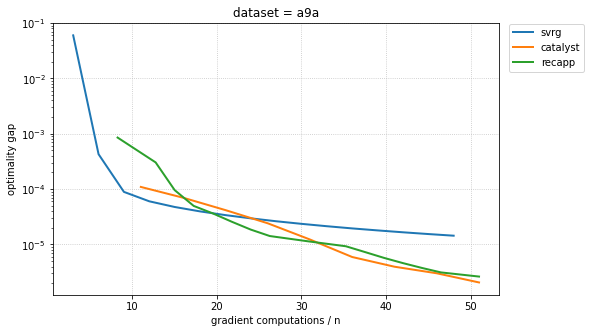

In [5]:
# Plot suboptimality
plt.figure(figsize=[8,5])
for alg, df in traces.items():
    plt.plot(df.set_index('budget_consumed').f_value - f_sklearn, label=alg, lw=2)
plt.xlabel('gradient computations / n')
plt.ylabel('optimality gap')
plt.title(f'dataset = {base_config.dataset}')
plt.yscale('log')
plt.grid(True, which='major', axis='y', color=[0.75, 0.75, 0.75], ls=':')
plt.grid(True, which='major', axis='x', color=[0.75, 0.75, 0.75], ls=':')
plt.legend(loc='upper left', bbox_to_anchor=[1.01, 1.015])
plt.show()